In [8]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt

In [9]:
train_dir = '/kaggle/input/d/msambare/fer2013/train/'
test_dir = '/kaggle/input/d/msambare/fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


<Axes: >

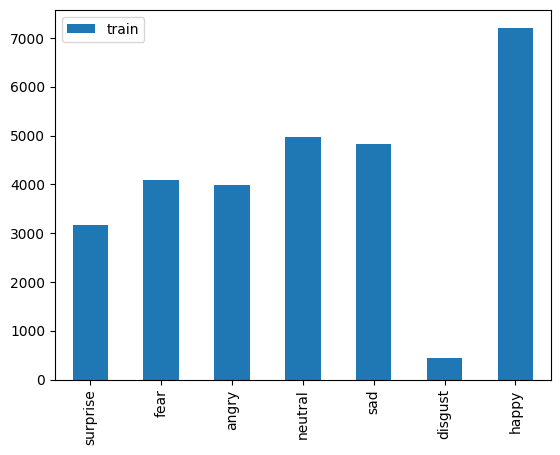

In [10]:
train_count.transpose().plot(kind='bar')

<Axes: >

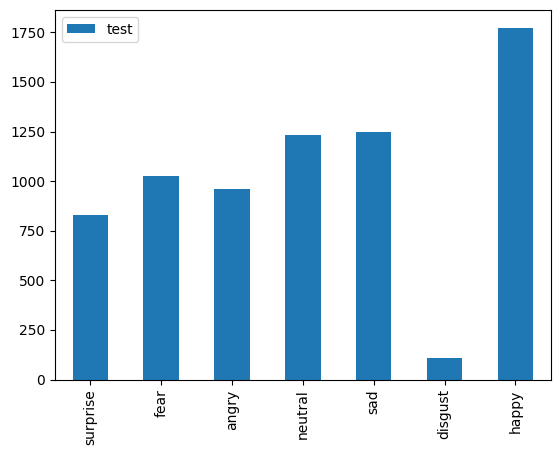

In [11]:
test_count.transpose().plot(kind='bar')

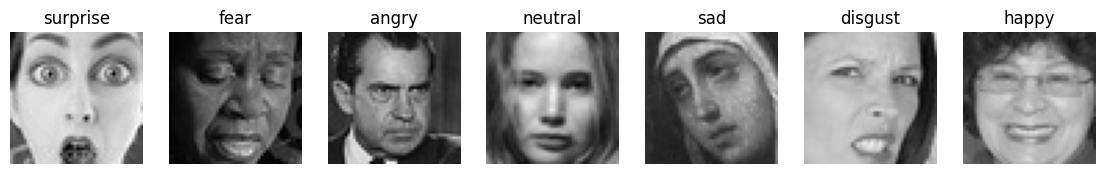

In [12]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.3,horizontal_flip=True)
training_set = train_datagen.flow_from_directory(train_dir,batch_size=32,target_size=(48,48),shuffle=True,color_mode='grayscale',class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,batch_size=32,target_size=(48,48),shuffle=True,color_mode='grayscale',class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [14]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Tentando usar uma GPU

In [15]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU


Definindo o modelo

In [16]:
def get_model(input_size, classes=7):
    model = tf.keras.models.Sequential()

    # Add a convolutional layer with 32 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
    # Add a batch normalization layer
    model.add(BatchNormalization())
    # Add a second convolutional layer with 64 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    # Add a second batch normalization layer
    model.add(BatchNormalization())
    # Add a max pooling layer with 2x2 pool size
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add a dropout layer with 0.25 dropout rate
    model.add(Dropout(0.25))

    # Add a third convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    # Add a third batch normalization layer
    model.add(BatchNormalization())
    # Add a fourth convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    # Add a fourth batch normalization layer
    model.add(BatchNormalization())
    # Add a max pooling layer with 2x2 pool size
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add a dropout layer with 0.25 dropout rate
    model.add(Dropout(0.25))

    # Add a fifth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    # Add a fifth batch normalization layer
    model.add(BatchNormalization())
    # Add a sixth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    # Add a sixth batch normalization layer
    model.add(BatchNormalization())
    # Add a max pooling layer with 2x2 pool size
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add a dropout layer with 0.25 dropout rate
    model.add(Dropout(0.25))

    # Flatten the output of the convolutional layers
    model.add(Flatten())
    # Add a dense layer with 256 neurons and relu activation function
    model.add(Dense(256, activation='relu'))
    # Add a seventh batch normalization layer
    model.add(BatchNormalization())
    # Add a dropout layer with 0.5 dropout rate
    model.add(Dropout(0.5))
    # Add a dense layer with 7 neurons (one for each class) and softmax activation function
    model.add(Dense(7, activation='softmax'))

    # Compile the model with categorical cross-entropy loss, adam optimizer, and accuracy metric
    model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model

In [17]:
fernet = get_model((48, 48, 1), 7)
fernet.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,394,183 (5.32 MB)

 Trainable params: 1,391,943 (5.31 MB)

 Non-trainable params: 2,240 (8.75 KB)

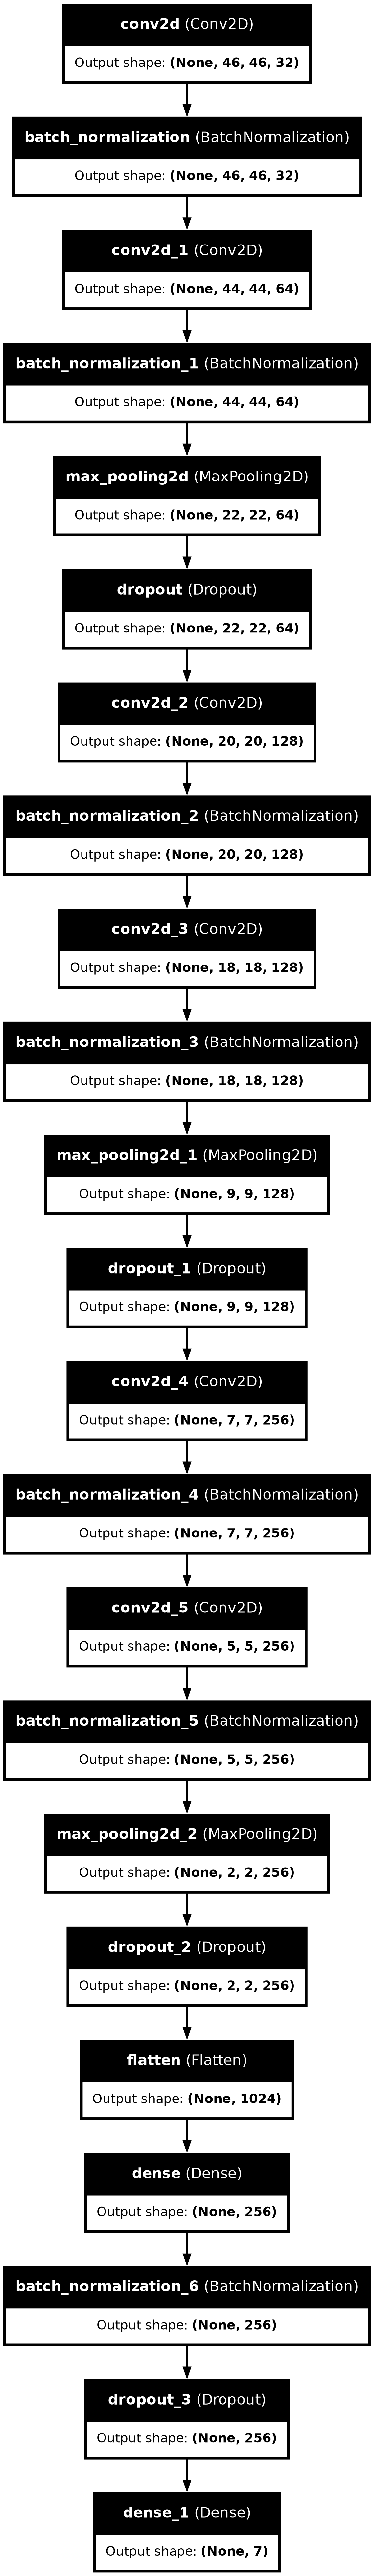

In [18]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

In [19]:
chk_path = 'model/ferNet.keras'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Callbacks
checkpoint = ModelCheckpoint(filepath=chk_path, save_best_only=True, verbose=1, mode='max', monitor='accuracy')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

# Incluindo todos os callbacks configurados, exceto EarlyStopping
callbacks = [checkpoint,tensorboard_callback, csv_logger]

In [20]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(
    x=training_set,
    validation_data=test_set,
    epochs=60,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-22 22:21:52.786742: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.07344, expected 3.39204
2024-04-22 22:21:52.786792: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.66488, expected 2.98347
2024-04-22 22:21:52.786802: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.34272, expected 2.66131
2024-04-22 22:21:52.786810: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.82969, expected 3.14828
2024-04-22 22:21:52.786818: E external/local_xla/xla/service/gpu/buffer_comparator.cc:11

  1/897 ━━━━━━━━━━━━━━━━━━━━ 4:09:04 17s/step - accuracy: 0.1875 - loss: 3.4510

I0000 00:00:1713824519.919763     140 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 57/897 ━━━━━━━━━━━━━━━━━━━━ 2:14 161ms/step - accuracy: 0.1370 - loss: 3.3035

2024-04-22 22:22:12.011292: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.99793, expected 3.03076
2024-04-22 22:22:12.011353: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.88436, expected 2.91718
2024-04-22 22:22:12.011363: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.35991, expected 2.39274
2024-04-22 22:22:12.011370: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.68773, expected 2.72056
2024-04-22 22:22:12.011378: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.69658, expected 2.7294
2024-04-22 22:22:12.011386: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.72959, expected 1.76242
2024-04-22 22:22:12.011394: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.97875, expected 2.01157
2024-04-22 22:22:12.011402: E external/local_xla/xla/ser

897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.1793 - loss: 2.8754
Epoch 1: accuracy improved from -inf to 0.19925, saving model to model/ferNet.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 199s 204ms/step - accuracy: 0.1793 - loss: 2.8752 - val_accuracy: 0.3200 - val_loss: 1.7880
Epoch 2/60
  1/897 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0938 - loss: 2.5768

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-22 22:25:02.735438: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.72957, expected 3.22517
2024-04-22 22:25:02.735497: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.53547, expected 3.03107
2024-04-22 22:25:02.735513: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.96167, expected 2.45728
2024-04-22 22:25:02.735527: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.76986, expected 3.26546
2024-04-22 22:25:02.735538: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.13185, expected 2.62745
2024


Epoch 2: accuracy did not improve from 0.19925
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0938 - loss: 2.5768 - val_accuracy: 0.4000 - val_loss: 1.5605
Epoch 3/60
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2405 - loss: 2.2858
Epoch 3: accuracy improved from 0.19925 to 0.25592, saving model to model/ferNet.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.2405 - loss: 2.2857 - val_accuracy: 0.3471 - val_loss: 1.7014
Epoch 4/60
  1/897 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3438 - loss: 1.9954
Epoch 4: accuracy improved from 0.25592 to 0.34375, saving model to model/ferNet.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step - accuracy: 0.3438 - loss: 1.9954 - val_accuracy: 0.4000 - val_loss: 1.6714
Epoch 5/60
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2967 - loss: 2.0442
Epoch 5: accuracy did not improve from 0.34375
897/897 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.2967 - loss: 2.0442 - val_accuracy: 0.3941 - val_loss: 1.5

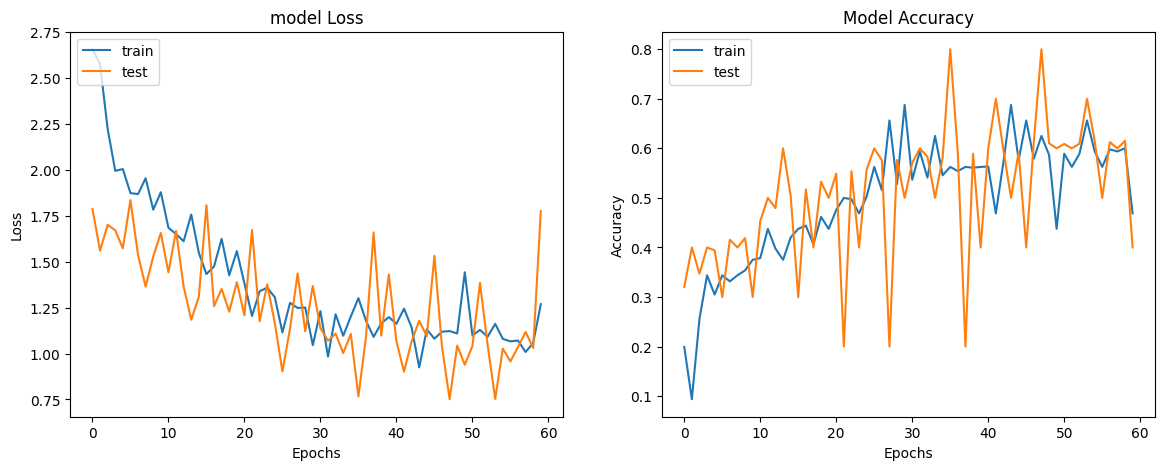

In [21]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))
fernet.save_weights('fernet_bestweight.weights.h5')

898/898 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.6501 - loss: 0.9322
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6224 - loss: 1.0239
final train accuracy = 64.88 , validation accuracy = 61.47


898/898 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step
Confusion Matrix
[[ 631   27  389 1129  749  580  490]
 [  64    1   44  143   70   55   59]
 [ 664   25  378 1099  822  602  507]
 [1094   39  698 1975 1480 1076  853]
 [ 803   33  461 1320  977  755  616]
 [ 730   30  446 1384  977  710  553]
 [ 496   27  305  847  655  514  327]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.16      0.15      3995
     disgust       0.01      0.00      0.00       436
        fear       0.14      0.09      0.11      4097
       happy       0.25      0.27      0.26      7215
     neutral       0.17      0.20      0.18      4965
         sad       0.17      0.15      0.16      4830
    surprise       0.10      0.10      0.10      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



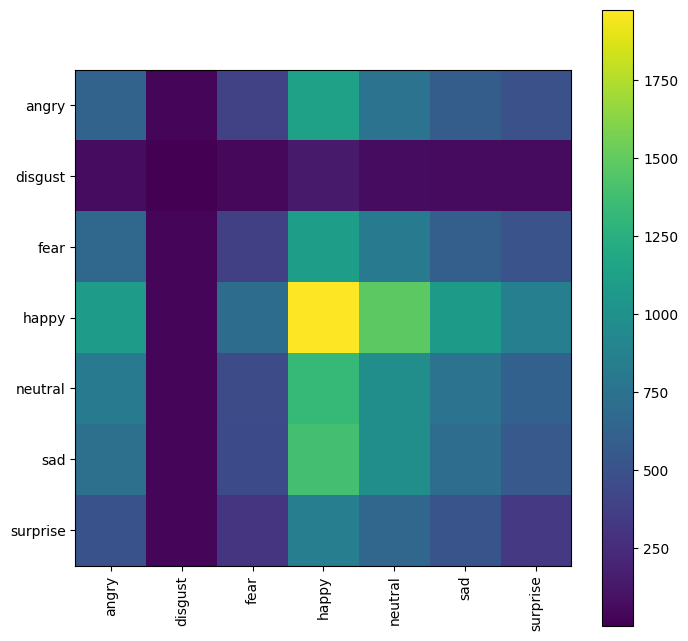

In [ ]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)